In [1]:
import numpy as np
import os
import random
import glob
import matplotlib.pyplot as plt
from copy import copy
import tensorflow as tf
from tensorflow.keras import layers
from scipy import misc
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
tf.executing_eagerly()

True

In [2]:
def get_images(paths, labels, nb_samples=None, shuffle=True):
    """
    Takes a set of character folders and labels and returns paths to image files
    paired with labels.
    Args:
        paths: A list of character folders
        labels: List or numpy array of same length as paths
        nb_samples: Number of images to retrieve per character
    Returns:
        List of (label, image_path) tuples
    """
    if nb_samples is not None:
        sampler = lambda x: random.sample(x, nb_samples)
    else:
        sampler = lambda x: x
    images_labels = [(i, os.path.join(path, image))
                     for i, path in zip(labels, paths)
                     for image in sampler(os.listdir(path))]
    if shuffle:
        random.shuffle(images_labels)
    return images_labels

In [3]:
def image_file_to_array(filename, dim_input):
    """
    Takes an image path and returns numpy array
    Args:
        filename: Image filename
        dim_input: Flattened shape of image
    Returns:
        1 channel image
    """
    image = misc.imread(filename)
    image = image.reshape([dim_input])
    image = image.astype(np.float32) / 255.0
    image = 1.0 - image
    return image

In [4]:
def plot_results(logs, NUM_CLASSES, NUM_SAMPLES):
    
    fig, ax = plt.subplots()
    steps = [x[0] for x in logs]
    train_loss = [x[1] for x in logs]
    test_loss = [x[2] for x in logs]
    acc = [x[3] for x in logs]
    ax.plot(steps, train_loss, label = 'train loss')
    ax.plot(steps, test_loss, label = 'test_loss')
    ax.plot(steps, acc, label = 'accuracy')
    ax.set(xlabel='Iterations', 
           title='MANN: {}-way classification, {}-shot'.format(NUM_CLASSES, NUM_SAMPLES))
    ax.grid()
    ax.legend()
    plt.savefig("{}-{}.png".format(NUM_CLASSES, NUM_SAMPLES))

In [5]:
class DataGenerator(object):
    
    def __init__(self, num_classes, num_samples_per_class):
        """
        Args:
            num_classes: Number of classes for classification (K-way)
            num_samples_per_class: num samples to generate per class in one batch
            batch_size: size of meta batch size (e.g. number of functions)
        """
        self.num_samples_per_class = num_samples_per_class
        self.num_classes = num_classes
        
        data_folder = './omniglot_resized'
        
        self.img_size = (28, 28)
        self.dim_input = np.prod(self.img_size)
        self.dim_output = self.num_classes
        
        character_folders = [os.path.join(data_folder, family, character)
                             for family in os.listdir(data_folder)
                             if os.path.isdir(os.path.join(data_folder, family))
                             for character in os.listdir(os.path.join(data_folder, family))
                             if os.path.isdir(os.path.join(data_folder, family, character))]
        
        random.seed(1)
        random.shuffle(character_folders)
        
        # using roughly 20% of data for meta-testing (1200:423)
        num_train = 1200
        
        self.metatrain_character_folders = character_folders[:num_train]
        self.metatest_character_folders = character_folders[num_train:]
        
    def sample_batch(self, batch_type, batch_size):
        """
        Samples a batch for training or testing
        Args:
            batch_type: train/test
        Returns:
            A a tuple of (1) Image batch and (2) Label batch where
            image batch has shape [B, K, N, 784] and label batch has shape [B, K, N, N]
            where B is batch size, K is number of samples per class, N is number of classes
        """
        if batch_type == "train":
            folders = self.metatrain_character_folders
        elif batch_type == "test":
            folders = self.metatest_character_folders
            
        B, K, N = batch_size, self.num_samples_per_class, self.num_classes
        
        all_image_batches = np.zeros((B, K, N, self.dim_input))
        all_label_batches = np.zeros((B, K, N, N))

        for batch_idx in range(B):
            sampled_classes = np.random.choice(folders, N, replace = False)
            one_hot_labels = np.eye(N)
            assert K == self.num_samples_per_class
            images_and_labels = get_images(sampled_classes, one_hot_labels, nb_samples=K, shuffle=False)
            
            images_train = []
            images_test = []
            labels_train = []
            labels_test = []
            for i, (label, image_path) in enumerate(images_and_labels):
                if i % K == 0:
                    images_test.append(image_path)
                    labels_test.append(label)
                else:
                    images_train.append(image_path)
                    labels_train.append(label)

            images_train, labels_train = shuffle(images_train, labels_train)
            images_test, labels_test = shuffle(images_test, labels_test)
 
            
            images_train = [image_file_to_array(x, self.dim_input) for x in images_train]
            images_test = [image_file_to_array(x, self.dim_input) for x in images_test]
            
            image_batches_train = np.array(images_train)
            label_batches_train = np.array(labels_train)
            image_batches_test = np.array(images_test)
            label_batches_test = np.array(labels_test)
            
            image_batches = np.concatenate([image_batches_train, image_batches_test], axis = 0).reshape(K, N, self.dim_input)
            label_batches = np.concatenate([label_batches_train, label_batches_test], axis = 0).reshape(K, N, N)
            
            all_image_batches[batch_idx, :, :, :] = image_batches
            all_label_batches[batch_idx, :, :, :] = label_batches
                
        return all_image_batches, all_label_batches

In [6]:
num_classes = 4
num_samples_per_class = 5
batch_size = 16

generator = DataGenerator(num_classes, num_samples_per_class)
batch_images, batch_labels = generator.sample_batch("train", batch_size)

/Users/damian/Code/stanford_ml_mt/sample_env/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


[1. 0. 0. 0.]


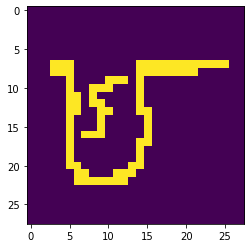

[0. 0. 0. 1.]


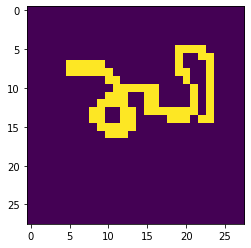

[0. 0. 1. 0.]


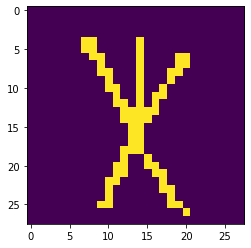

[0. 1. 0. 0.]


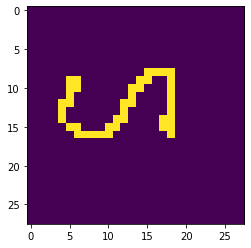

In [7]:
batch_idx = 15
image_index = -1
sample_images, sample_labels = batch_images[batch_idx, image_index, :, :], batch_labels[batch_idx, image_index, :, :]
for i, j in zip(sample_images, sample_labels):
    print(j)
    plt.imshow(np.uint8(i.reshape(28, 28)))
    plt.show()

In [8]:
class MANN(tf.keras.Model):
    def __init__(self, num_classes, samples_per_class, lstm_size, conv = False):
        super(MANN, self).__init__()
        self.num_classes = num_classes
        self.samples_per_class = samples_per_class
        self.conv = conv
        
        self.conv_1 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer = 'he_uniform')
        self.dense_1 = tf.keras.layers.Dense(100)
        self.layer_pool = tf.keras.layers.MaxPooling2D((2,2))
        self.layer_flatten = tf.keras.layers.Flatten()
        
        self.lstm_1 = tf.keras.layers.LSTM(lstm_size, return_sequences = True)
        self.lstm_2 = tf.keras.layers.LSTM(num_classes, return_sequences = True)
        
    def call(self, input_images, input_labels):
        """
        MANN
        Args:
            input_images: [B, K+1, N, 784] flattened images
            labels: [B, K+1, N, N] ground truth labels
        Returns:
            [B, K+1, N, N] predictions
        """
        B, Kplusone, N, D = input_images.shape
        K = Kplusone - 1
        input_labels = tf.dtypes.cast(input_labels, tf.float32)
        input_labels = tf.concat([input_labels[:, :-1],
                                  tf.zeros_like(input_labels[:, -1:])], axis = 1)        
        if self.conv:
            image_dims = 28
            input_images = tf.reshape(input_images, (B * Kplusone * N, image_dims, image_dims, 1))
            input_images = self.dense_1(self.layer_flatten(self.layer_pool(self.conv_1(input_images))))
            input_images = tf.reshape(input_images, (B, Kplusone, N, -1))
            x = tf.concat([input_images, input_labels], axis = 3)
            x = tf.reshape(x, (B, Kplusone * N, -1))
   
        else:
            x = tf.concat([input_images, input_labels], axis = 3)
            x = tf.reshape(x, (B, Kplusone * N, D + N))
            
        out = self.lstm_2(self.lstm_1(x))
        out = tf.reshape(out, (B, Kplusone, N, N))

        return out

In [9]:
def loss_function(preds, labels):
    """
    Computes MANN loss
    Args:
        preds: [B, K+1, N, N] network output
        labels: [B, K+1, N, N] labels
    Returns:
        scalar loss
    """
    last_y_preds = preds[:, -1:]
    last_y_labels = labels[:, -1:]
    loss = tf.keras.losses.categorical_crossentropy(last_y_labels, last_y_preds, from_logits=True)
    loss = tf.reduce_mean(loss)
    
    return loss

In [10]:
@tf.function
def train_step(inputs, labels, model, loss_object, optimizer):
    with tf.GradientTape() as tape:
        predictions = model(inputs, labels, training=True)
        loss = loss_object(predictions, labels)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss
    
@tf.function
def test_step(inputs, labels, model, loss_object):
    predictions = model(inputs, labels, training=False)
    loss = loss_object(predictions, labels)
    return loss, predictions


In [11]:
def train_MANN(NUM_CLASSES = 5, NUM_SAMPLES = 1, META_BATCH_SIZE = 64, ITERATIONS = 50000, LSTM_SIZE = 128, CONV = False):
    """
    NUM_CLASSES        'number of classes used in classification (e.g. 5-way classification)
    NUM_SAMPLES        'number of examples used for inner gradient update (K for K-shot learning).'
    META_BATCH_SIZE    'number of N-way classification tasks per batch'
    """
    
    logs = []

    data_generator = DataGenerator(NUM_CLASSES, NUM_SAMPLES + 1)
    
    o = MANN(NUM_CLASSES, NUM_SAMPLES + 1, LSTM_SIZE, CONV)
    loss = loss_function
    optimizer = tf.keras.optimizers.Adam(0.001)

    for step in range(ITERATIONS):
        images_batch, labels_batch = data_generator.sample_batch('train', META_BATCH_SIZE)
        train_loss = train_step(images_batch, labels_batch, o, loss, optimizer)
        if step % 1000 == 0:
            print("*" * 5 + "Iteration no. {}".format(step) + "*" * 5)

            images_batch_test, labels_batch_test = data_generator.sample_batch('test', 300)
            test_loss, preds = test_step(images_batch_test, labels_batch_test, o, loss)
            preds = preds.numpy().reshape(-1, NUM_SAMPLES + 1, NUM_CLASSES, NUM_CLASSES)
            preds = preds[:, -1, :, :].argmax(2)
            labels_batch_test = labels_batch_test[:, -1, :, :].argmax(2)

            print("Train Loss: {} Test Loss: {}".format(train_loss.numpy(), test_loss.numpy()))
            accuracy = (1.0 * (preds == labels_batch_test)).mean()
            print("Test Accuracy", accuracy)

            logs.append((step, train_loss, test_loss, accuracy))

    plot_results(logs, NUM_CLASSES, NUM_SAMPLES)

In [ ]:
# fix K vary N
for NUM_CLASSES in [2,3,4]:
    NUM_SAMPLES = 1
    train_MANN(NUM_CLASSES, NUM_SAMPLES, CONV = False)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



/Users/damian/Code/stanford_ml_mt/sample_env/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


*****Iteration no. 0*****
Train Loss: 0.6941792964935303 Test Loss: 0.6959450244903564
Test Accuracy 0.5
*****Iteration no. 1000*****
Train Loss: 0.6293325424194336 Test Loss: 0.5899530649185181
Test Accuracy 0.6033333333333334
*****Iteration no. 2000*****
Train Loss: 0.45721012353897095 Test Loss: 0.5178144574165344
Test Accuracy 0.6866666666666666
*****Iteration no. 3000*****
Train Loss: 0.40829434990882874 Test Loss: 0.43099862337112427
Test Accuracy 0.85
*****Iteration no. 4000*****
Train Loss: 0.381076842546463 Test Loss: 0.3954070210456848
Test Accuracy 0.8483333333333334
*****Iteration no. 5000*****
Train Loss: 0.3802157938480377 Test Loss: 0.336791068315506
Test Accuracy 0.8916666666666667
*****Iteration no. 6000*****
Train Loss: 0.3617760241031647 Test Loss: 0.3291057050228119
Test Accuracy 0.8983333333333333
*****Iteration no. 7000*****
Train Loss: 0.3642581105232239 Test Loss: 0.3533407151699066
Test Accuracy 0.875
*****Iteration no. 8000*****
Train Loss: 0.265325129032135 T